<h1><font color=red> Quora Question pair Similarity Case study </font></h1>

In [1]:
# Importing all the neccessary libraries and packages

import warnings
warnings.filterwarnings("ignore")
import sqlite3
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc
import re
import distance
import math
import spacy

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from subprocess import check_output

from datetime import datetime as dt
from collections import Counter
from scipy.sparse import hstack
from mlxtend.classifier import StackingClassifier
from tqdm import tqdm
from datetime import datetime as dt

from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

# Reading Data

In [2]:
df = pd.read_csv("train.csv")

print("Shape of dataframe : ", df.shape)
print("Total data points : ", df.shape[0])

Shape of dataframe :  (404290, 6)
Total data points :  404290


In [3]:
# Printing top Data points
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [5]:
# Info of dataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


# Distribution of data points among output classes

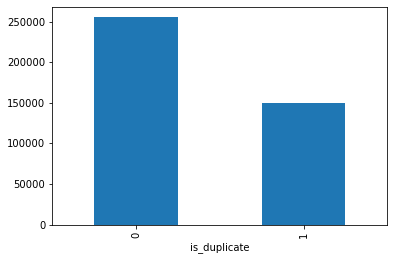

In [6]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [11]:
print("Total number of question pairs for training :  {}".format(len(df)))

Total number of question pairs for training :  404290


In [10]:
print("Question pairs are not Similar (is_duplicate = 0) :  {}%".format(100 - round(df['is_duplicate'].mean()*100, 2)))
print("\nQuestion pairs are Similar (is_duplicate = 1) :  {}%".format(round(df['is_duplicate'].mean()*100, 2)))

Question pairs are not Similar (is_duplicate = 0) :  63.08%

Question pairs are Similar (is_duplicate = 1) :  36.92%


## Observations 

- We can see that there are total 404290 datapoints and out of which 63.08% of datapoints are not similar and arounf 39.62% of data are similar.
- Means there are more number of datapoints that are not similar.

# Number of unique questions

In [12]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)

print ("Total number of  Unique Questions are : {}".format(unique_qs))
print ("\nNumber of unique questions that appear more than one time : {} ({}%)".format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
print ("\nMax number of times a single question is repeated: {}".format(max(qids.value_counts()))) 

q_vals=qids.value_counts()
q_vals=q_vals.values

Total number of  Unique Questions are : 537933

Number of unique questions that appear more than one time : 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157


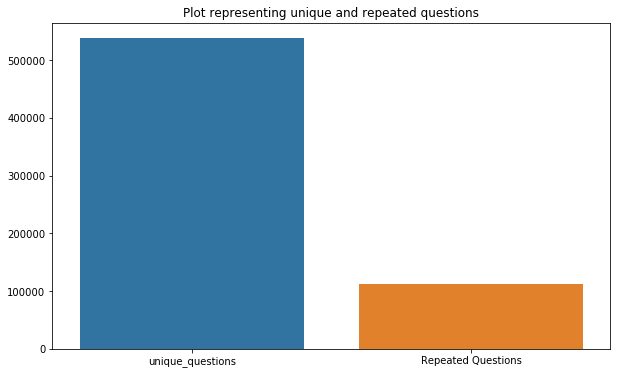

In [13]:
x = ["unique_questions" , "Repeated Questions"]
y = [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title("Plot representing unique and repeated questions")
sns.barplot(x,y)
plt.show()

## Observations

- As seen from plot above we can see that the number of unique questions are far more than repeated questions
- There are total of 537933 unique questions
- There are total 111780 repeated questions

# checking for Duplicates

In [14]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print ("Number of duplicate questions : ", (pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions :  0


## Observations

- There are no question pair which are repeated

# Number of occurrences of each question

Maximum number of times a single question is repeated: 157


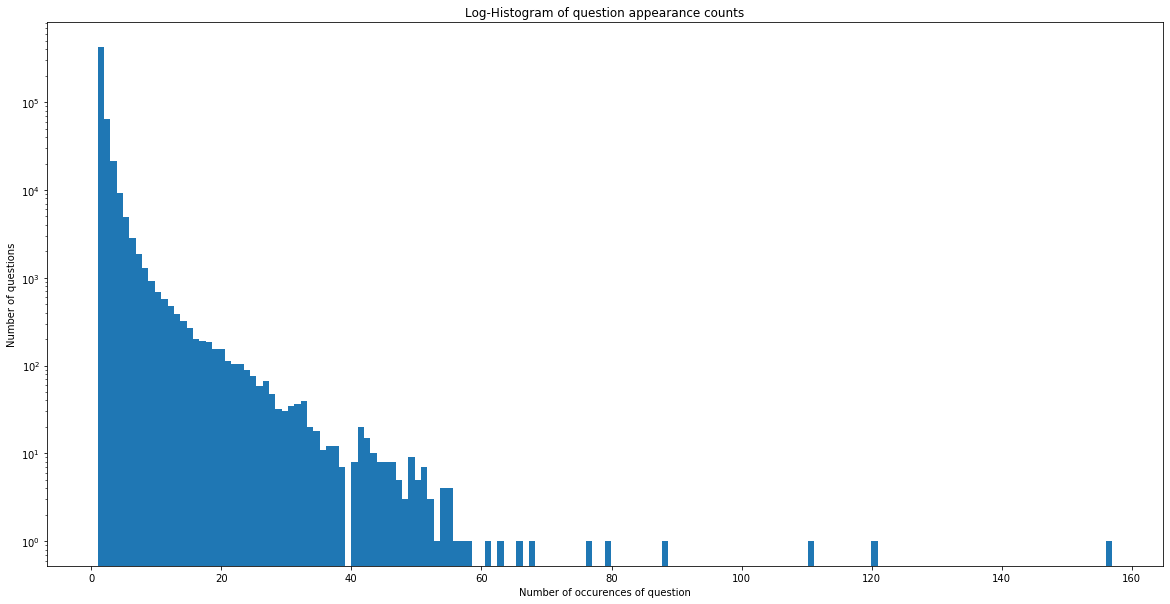

In [15]:
plt.figure(figsize=(20, 10))
plt.hist(qids.value_counts(), bins=160)
plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print("Maximum number of times a single question is repeated: {}".format(max(qids.value_counts())))

## Observations

- Most of Questions occur less than 60 times
- There is a question which occured 157 times

# Checking for NULL values

In [16]:
#Checking whether there are any rows with null values

nan_rows = df[df.isnull().any(1)]
print(nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


## Observations

- There are some null values in our data
- We need to fill all the null values

In [17]:
# Filling the null values with ' '

df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


# Basic Feature Extraction (before cleaning)

Let us now construct a few features like:

- freq_qid1 = Frequency of qid1's
- freq_qid2 = Frequency of qid2's
- q1len = Length of q1
- q2len = Length of q2
- q1_n_words = Number of words in Question 1
- q2_n_words = Number of words in Question 2
- word_Common = (Number of common unique words in Question 1 and Question 2)
- word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
- word_share = (word_common)/(word_Total)
- freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
- freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2

In [18]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   
2  How can Internet speed be increased by hacking...             0          1   
3  Find the remainder when [math]23^{24}[/math] i...             0          1   
4            Which fish would survive in salt water?             0          3   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
0          1     66     57          14          12         10.0        23.0   
1          1     51     88           8          13          4.0        20.0   
2          1     73     59          14          10          4.0        24.0   
3          1     50     65          11           9          0.0        19.0   
4          1     76     39          13           7          2.0        20.0   

   word_share  freq_q1+q2  freq_q1-q2  
0    0.434783           2           0  
1    0.200000           5           3  
2    0.166667           2           0  
3    0.000000           2           0  
4    0.100000           4           2

# Analysis of some of the extracted features

In [19]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))
print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] : ", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] : ", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] :  67
Number of Questions with minimum length [question2] :  24


## Feature: word_share

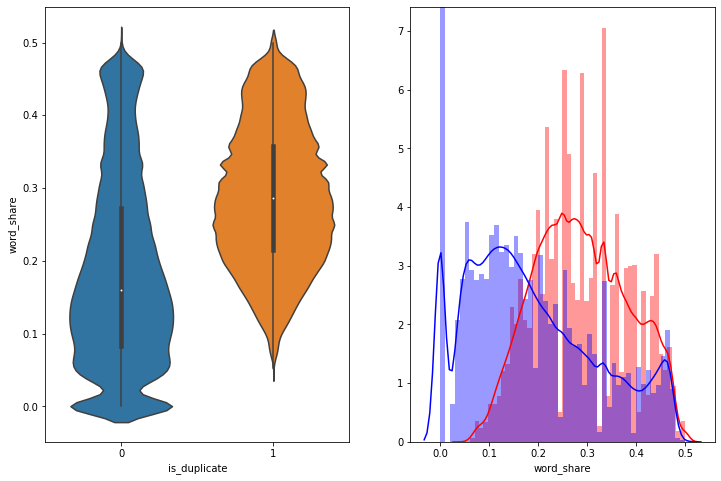

In [21]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0", color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

## Feature: word_Common

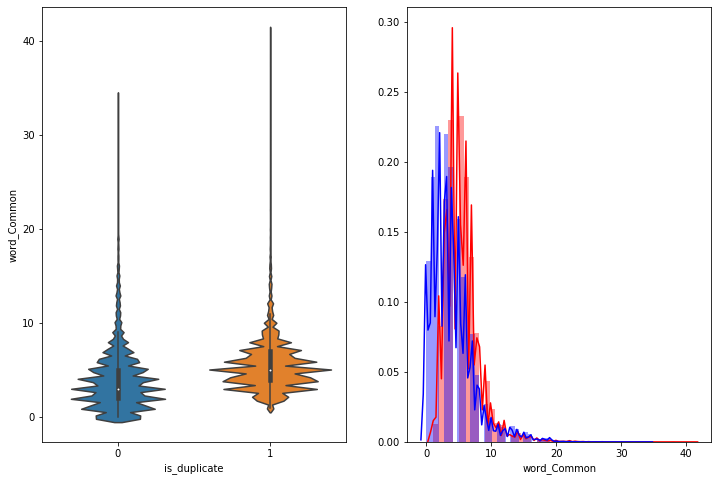

In [22]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions of the word_Common feature in similar and non-similar questions are highly overlapping.

# Preprocessing of Text

In [24]:
import nltk
nltk.download('stopwords')

# To get the results in 4 decemal points
SAFE_DIV = 0.0001 
STOP_WORDS = stopwords.words("english")

def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    return x

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


# Advanced Feature Extraction (NLP and Fuzzy Features)

In [25]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [28]:
from fuzzywuzzy import fuzz
print("Extracting features for train:")
df = pd.read_csv("train.csv")
df = extract_features(df)
df.to_csv("nlp_features_train.csv", index=False)
df.head()

Extracting features for train:
token features...
fuzzy features..


id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   
2   2     5     6  how can i increase the speed of my internet co...   
3   3     7     8  why am i mentally very lonely  how can i solve...   
4   4     9    10  which one dissolve in water quikly sugar  salt...   

                                           question2  is_duplicate   cwc_min  \
0  what is the step by step guide to invest in sh...             0  0.999980   
1  what would happen if the indian government sto...             0  0.799984   
2  how can internet speed be increased by hacking...             0  0.399992   
3  find the remainder when  math 23  24   math  i...             0  0.000000   
4            which fish would survive in salt water              0  0.399992   

    cwc_max   csc_min   csc_max  ...   ctc_max  last_word_eq  first_word_eq  \
0  0.833319  0.999983  0.999983  ...  0.785709           0.0            1.0   
1  0.399996  0.749981  0.599988  ...  0.466664           0.0            1.0   
2  0.333328  0.399992  0.249997  ...  0.285712           0.0            1.0   
3  0.000000  0.000000  0.000000  ...  0.000000           0.0            0.0   
4  0.199998  0.999950  0.666644  ...  0.307690           0.0            1.0   

   abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  fuzz_ratio  \
0           2.0      13.0              100                93          93   
1           5.0      12.5               86                63          66   
2           4.0      12.0               63                63          43   
3           2.0      12.0               28                24           9   
4           6.0      10.0               67                47          35   

   fuzz_partial_ratio  longest_substr_ratio  
0                 100              0.982759  
1                  75              0.596154  
2                  47              0.166667  
3                  14              0.039216  
4                  56              0.175000  

[5 rows x 21 columns]

# Analysis of extracted features

## Plotting Word clouds

In [30]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :", len(p))
print ("Number of data points in class 0 (non duplicate pairs) :", len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s',encoding='utf-8')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s',encoding='utf-8')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [32]:
# reading the text files and removing the Stop Words:
from wordcloud import WordCloud, STOPWORDS
from os import path
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt'), encoding="utf-8").read()
textn_w = open(path.join(d, 'train_n.txt'), encoding="utf-8").read()



stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33193067


Word Cloud for Duplicate Question pairs


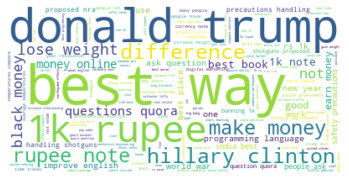

In [33]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Observations

- In Duplicate questions there are more occurance of words like donald, trump, best, waym rupee, etc.
- According to kaggle site this dataset was from june, 2017 and in january, 2017 trump was elected as president. So it is obvious that there may be more questions related to donald trump.

Word Cloud for non-Duplicate Question pairs:


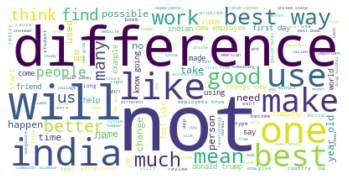

In [34]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Observations

- For Non-duplicate questions thera are words like difference, not, will, india that occures more as compare to other words.

## Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']

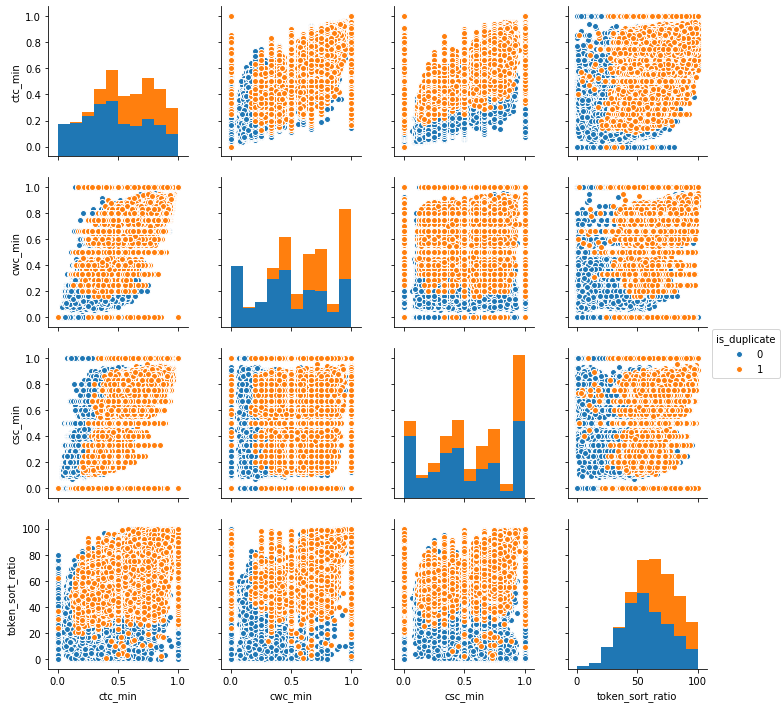

In [35]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

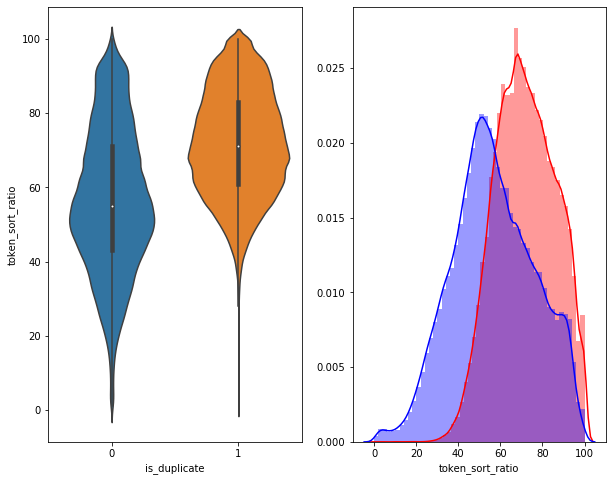

In [36]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

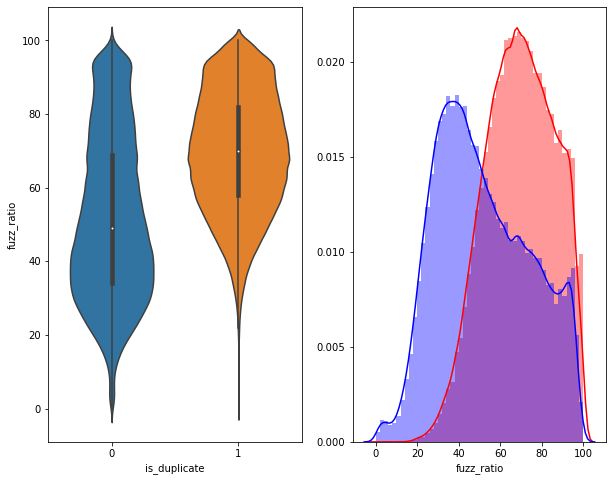

In [37]:
plt.figure(figsize=(10, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

# Visualization

In [38]:
from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [39]:
tsne2d = TSNE(n_components=2, init='random', random_state=101, method='barnes_hut', n_iter=1000, verbose=2, angle=0.5).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.221s...
[t-SNE] Computed neighbors for 5000 samples in 0.849s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.623s
[t-SNE] Iteration 50: error = 81.3425446, gradient norm = 0.0466835 (50 iterations in 3.747s)
[t-SNE] Iteration 100: error = 70.6490860, gradient norm = 0.0087385 (50 iterations in 3.002s)
[t-SNE] Iteration 150: error = 68.9494553, gradient norm = 0.0055224 (50 iterations in 2.898s)
[t-SNE] Iteration 200: error = 68.1286011, gradient norm = 0.0044136 (50 iterations in 2.985s)
[t-SNE] Iteration 250: error = 67.6222382, gradient norm = 0.0040027

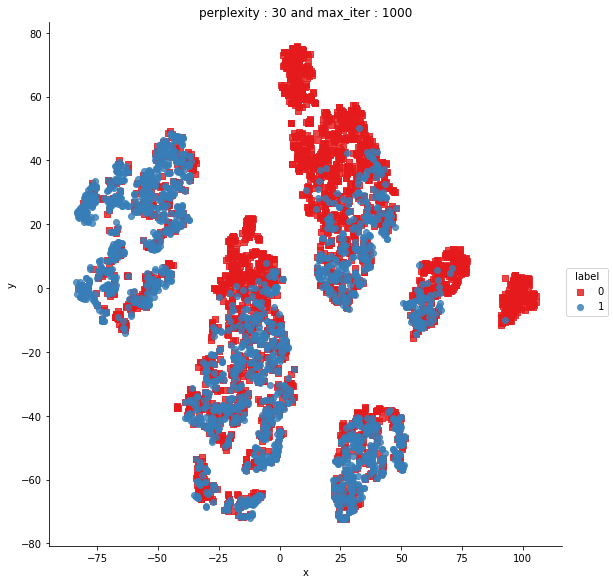

In [40]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [41]:
tsne3d = TSNE(n_components=3, init='random', random_state=101, method='barnes_hut', n_iter=1000, verbose=2, angle=0.5).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.029s...
[t-SNE] Computed neighbors for 5000 samples in 0.764s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.443s
[t-SNE] Iteration 50: error = 80.5739899, gradient norm = 0.0296227 (50 iterations in 9.567s)
[t-SNE] Iteration 100: error = 69.4174042, gradient norm = 0.0032491 (50 iterations in 5.637s)
[t-SNE] Iteration 150: error = 68.0031281, gradient norm = 0.0017356 (50 iterations in 5.279s)
[t-SNE] Iteration 200: error = 67.4430008, gradient norm = 0.0010772 (50 iterations in 5.410s)
[t-SNE] Iteration 250: error = 67.1309662, gradient norm = 0.0008710

In [44]:
import plotly.graph_objs as go
import plotly.offline as py
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

# Featurizing text data with Tf-idf W2V

In [45]:
df = pd.read_csv("train.csv")
 
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit_transform(questions)

word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [50]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
import en_core_web_sm
nlp = en_core_web_sm.load()
#nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)

100%|████████████████████████████████████████████████████████████████████████| 404290/404290 [1:14:02<00:00, 91.01it/s]


In [52]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|████████████████████████████████████████████████████████████████████████| 404290/404290 [1:42:52<00:00, 65.50it/s]


In [53]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro  = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    
dfppro.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   
2  How can Internet speed be increased by hacking...             0          1   
3  Find the remainder when [math]23^{24}[/math] i...             0          1   
4            Which fish would survive in salt water?             0          3   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
0          1     66     57          14          12         10.0        23.0   
1          1     51     88           8          13          4.0        20.0   
2          1     73     59          14          10          4.0        24.0   
3          1     50     65          11           9          0.0        19.0   
4          1     76     39          13           7          2.0        20.0   

   word_share  freq_q1+q2  freq_q1-q2  
0    0.434783           2           0  
1    0.200000           5           3  
2    0.166667           2           0  
3    0.000000           2           0  
4    0.100000           4           2

In [54]:
#nlp_features_train.csv (NLP Features)
if os.path.isfile('train.csv'):
    dfnlp = pd.read_csv("train.csv",nrows=50000,encoding='latin-1')
    
dfnlp.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [55]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [56]:
# Questions 1 tfidf weighted word2vec
print("Question 1 Tf-Idf W2V : ")
df3_q1.head()

# Questions 2 tfidf weighted word2vec
print("Question 2 Tf-Idf W2V : ")
df3_q2.head()

Question 1 Tf-Idf W2V : 
Question 2 Tf-Idf W2V : 


0          1           2          3           4           5   \
0  -14.616981  59.755488  -53.263745  19.514497  113.916473  101.657056   
1   -3.565742 -16.844571 -130.911785   0.320254   79.350278   23.562028   
2  156.833630  59.991896   -8.414311  29.251426  133.680218  112.457566   
3   41.472439  56.717317   31.530616  -5.520164   33.454800   79.596179   
4  -14.446975  -4.338255  -70.196208 -48.636382   18.356858  -50.807069   

          6          7           8           9   ...         86         87  \
0   8.561499  66.232769   32.888127  210.812733  ... -72.266625 -37.072086   
1  79.124551  84.119839  128.684135  279.539877  ...   6.193171 -65.084229   
2  89.849781  21.613022   24.331766  171.114490  ... -26.185226 -19.283218   
3  15.508996  40.042066   21.094017  101.998116  ... -17.779019  30.152297   
4  24.311196  60.043674   32.421993   57.148702  ...  36.089472  47.193216   

          88         89         90          91         92          93  \
0 -31.142730  94.064854 -45.053242  -34.155221 -76.548099   99.282776   
1 -15.654534  -3.475828  26.999802  170.172613 -57.038953  194.269546   
2  75.602438  24.144027 -91.874398 -178.454113 -91.471482   19.922719   
3  49.300137  27.783795  25.937188  -32.107076  -3.817634  -14.231000   
4 -49.969586  44.796028  39.740803  -33.763309 -98.282341   22.118795   

           94         95  
0   50.791731 -17.566246  
1  128.207803  55.490061  
2   21.266690  49.574858  
3    4.772115   7.711628  
4   68.802072  21.025373  

[5 rows x 96 columns]

In [57]:
print("Number of features in nlp dataframe : ", df1.shape[1])
print("Number of features in preprocessed dataframe : ", df2.shape[1])
print("Number of features in question1 w2v  dataframe : ", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe : ", df3_q2.shape[1])
print("Number of features in final dataframe  : ", df1.shape[1] + df2.shape[1] + df3_q1.shape[1] + df3_q2.shape[1])

Number of features in nlp dataframe :  2
Number of features in preprocessed dataframe :  12
Number of features in question1 w2v  dataframe :  96
Number of features in question2 w2v  dataframe :  96
Number of features in final dataframe  :  206


In [58]:
# storing the final features to csv file
if not os.path.isfile('final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1  = df1.merge(df2, on='id',how='left')
   # df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')

# Machine Learning Models

## Reading data from file and storing into sql table

In [59]:
if os.path.isfile('final_features.csv'):
    data = pd.read_csv('final_features.csv', nrows=50000, encoding = 'utf-8')
    
data.head()

Unnamed: 0  id  is_duplicate  freq_qid1_x  freq_qid2_x  q1len_x  q2len_x  \
0           0   0             0            1            1       66       57   
1           1   1             0            4            1       51       88   
2           2   2             0            1            1       73       59   
3           3   3             0            1            1       50       65   
4           4   4             0            3            1       76       39   

   q1_n_words_x  q2_n_words_x  word_Common_x  ...  freq_qid2_y  q1len_y  \
0            14            12           10.0  ...            1       66   
1             8            13            4.0  ...            1       51   
2            14            10            4.0  ...            1       73   
3            11             9            0.0  ...            1       50   
4            13             7            2.0  ...            1       76   

   q2len_y  q1_n_words_y  q2_n_words_y  word_Common_y  word_Total_y  \
0       57            14            12           10.0          23.0   
1       88             8            13            4.0          20.0   
2       59            14            10            4.0          24.0   
3       65            11             9            0.0          19.0   
4       39            13             7            2.0          20.0   

   word_share_y  freq_q1+q2_y  freq_q1-q2_y  
0      0.434783             2             0  
1      0.200000             5             3  
2      0.166667             2             0  
3      0.000000             2             0  
4      0.100000             4             2  

[5 rows x 25 columns]

## Random train test split

In [60]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, data['is_duplicate'], stratify=data['is_duplicate'], random_state=5)

In [61]:
# Printing Shape and top datapoints

print(X_train.shape)
X_train.head()

(37500, 25)


Unnamed: 0     id  is_duplicate  freq_qid1_x  freq_qid2_x  q1len_x  \
46084       46084  46084             1            5            1       39   
31337       31337  31337             1            8           18       47   
20200       20200  20200             0            1            1       94   
498           498    498             0            1            1       51   
39170       39170  39170             1            2            1       62   

       q2len_x  q1_n_words_x  q2_n_words_x  word_Common_x  ...  freq_qid2_y  \
46084       46             6             6            5.0  ...            1   
31337       41             6             6            3.0  ...           18   
20200      103            15            20            5.0  ...            1   
498         44            10             9            2.0  ...            1   
39170       49            14            11            6.0  ...            1   

       q1len_y  q2len_y  q1_n_words_y  q2_n_words_y  word_Common_y  \
46084       39       46             6             6            5.0   
31337       47       41             6             6            3.0   
20200       94      103            15            20            5.0   
498         51       44            10             9            2.0   
39170       62       49            14            11            6.0   

       word_Total_y  word_share_y  freq_q1+q2_y  freq_q1-q2_y  
46084          12.0      0.416667             6             4  
31337          12.0      0.250000            26            10  
20200          32.0      0.156250             2             0  
498            18.0      0.111111             2             0  
39170          25.0      0.240000             3             1  

[5 rows x 25 columns]

In [62]:
# extraction  features from train  data frame 
X_train = X_train.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=False)

# extraction  features from test data frame 
X_test = X_test.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=False)

print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (37500, 22)
Number of data points in test data : (12500, 22)


In [63]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6270133333333333 Class 1:  0.3729866666666667
---------- Distribution of output variable in train data ----------
Class 0:  0.37296 Class 1:  0.37296


In [64]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# Building a random model (Finding worst-case log-loss)

Log loss on Test Data using Random Model 0.8879535793508352


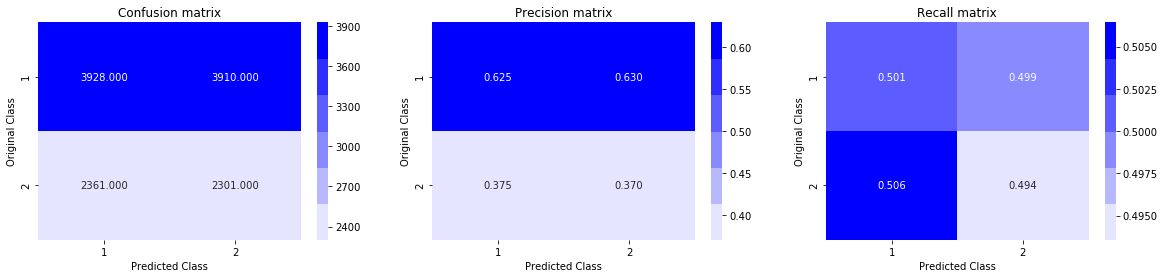

In [65]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

# Logistic Regression with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.4767806610875794
For values of alpha =  0.0001 The log loss is: 0.4794587001597146
For values of alpha =  0.001 The log loss is: 0.47167497782904216
For values of alpha =  0.01 The log loss is: 0.47308761367642094
For values of alpha =  0.1 The log loss is: 0.47945620818593515
For values of alpha =  1 The log loss is: 0.48210605709028576
For values of alpha =  10 The log loss is: 0.5233189937953077


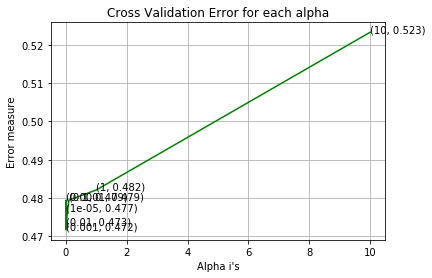

For values of best alpha =  0.001 The train log loss is: 0.46583289810755885
For values of best alpha =  0.001 The test log loss is: 0.47167497782904216
Total number of data points : 12500


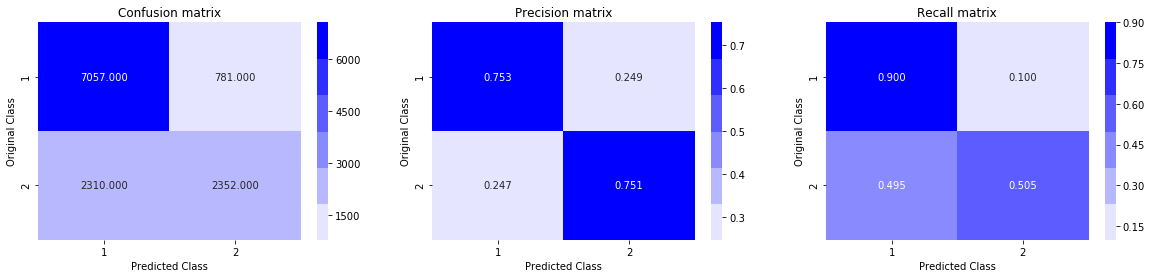

In [66]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.




log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Linear SVM with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.478400248542998
For values of alpha =  0.0001 The log loss is: 0.47900869710685606
For values of alpha =  0.001 The log loss is: 0.4765817779308944
For values of alpha =  0.01 The log loss is: 0.5229824110049747
For values of alpha =  0.1 The log loss is: 0.4936434387231388
For values of alpha =  1 The log loss is: 0.5809380979910945
For values of alpha =  10 The log loss is: 0.6427164188857588


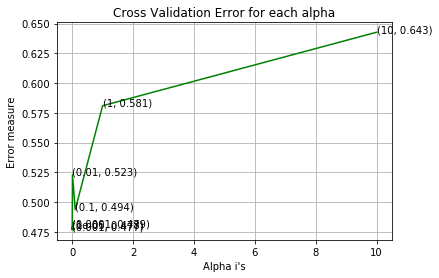

For values of best alpha =  0.001 The train log loss is: 0.4706994417690217
For values of best alpha =  0.001 The test log loss is: 0.4765817779308944
Total number of data points : 12500


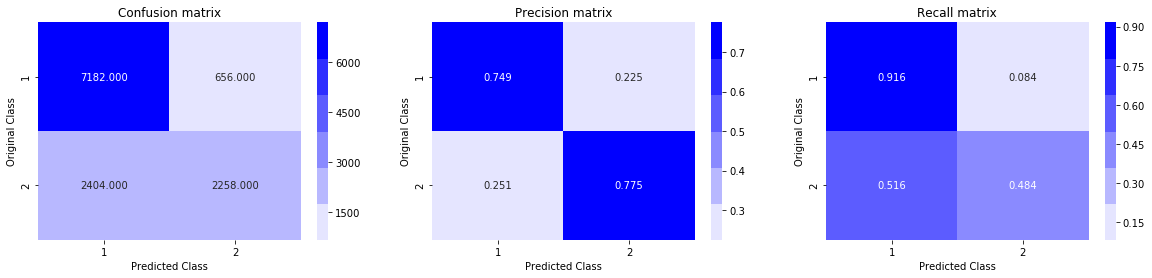

In [67]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.




log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# XGBoost

In [68]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.68523	valid-logloss:0.68532
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.61993	valid-logloss:0.62095
[20]	train-logloss:0.57305	valid-logloss:0.57494
[30]	train-logloss:0.53787	valid-logloss:0.54027
[40]	train-logloss:0.51154	valid-logloss:0.51434
[50]	train-logloss:0.49091	valid-logloss:0.49411
[60]	train-logloss:0.47503	valid-logloss:0.47863
[70]	train-logloss:0.46224	valid-logloss:0.46623
[80]	train-logloss:0.45166	valid-logloss:0.45606
[90]	train-logloss:0.44313	valid-logloss:0.44789
[100]	train-logloss:0.43628	valid-logloss:0.44129
[110]	train-logloss:0.43056	valid-logloss:0.43582
[120]	train-logloss:0.42584	valid-logloss:0.43139
[130]	train-logloss:0.42210	valid-logloss:0.42790
[140]	train-logloss:0.41885	valid-logloss:0.42495
[150]	train-logloss:0.41621	valid-logloss:0.42248
[160]	train-logloss:0.41401	valid-logloss:0.42046
[170]	trai

Total number of data points : 12500


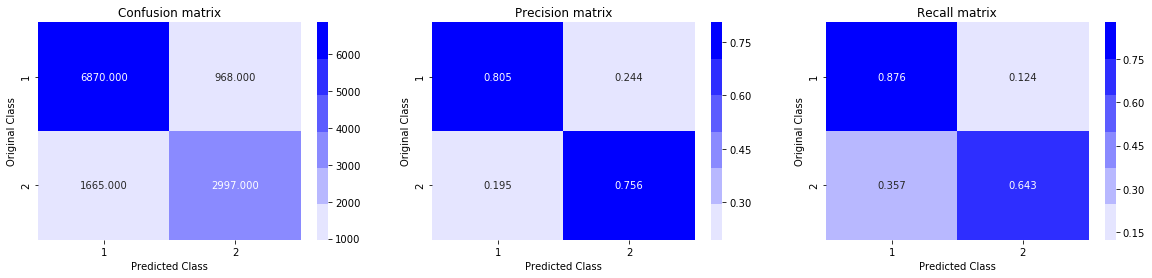

In [69]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Applying Tf-Idf vector instead of Tf-Idf W2V

In [72]:
# Selecting 60k points

if os.path.isfile('nlp_features_train.csv'):
    nlp = pd.read_csv("nlp_features_train.csv", nrows = 60000, encoding='latin-1')

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    pre_pro = pd.read_csv("df_fe_without_preprocessing_train.csv", encoding='latin-1')
    
pre_pro2 = pre_pro.drop(['qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], axis=1)
nlp2 = nlp.merge(pre_pro2, on='id', how='left')

In [73]:
# Printing top values of nlp2

nlp2.head()

id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   
2   2     5     6  how can i increase the speed of my internet co...   
3   3     7     8  why am i mentally very lonely  how can i solve...   
4   4     9    10  which one dissolve in water quikly sugar  salt...   

                                           question2  is_duplicate   cwc_min  \
0  what is the step by step guide to invest in sh...             0  0.999980   
1  what would happen if the indian government sto...             0  0.799984   
2  how can internet speed be increased by hacking...             0  0.399992   
3  find the remainder when  math 23  24   math  i...             0  0.000000   
4            which fish would survive in salt water              0  0.399992   

    cwc_max   csc_min   csc_max  ...  freq_qid2  q1len  q2len  q1_n_words  \
0  0.833319  0.999983  0.999983  ...          1     66     57          14   
1  0.399996  0.749981  0.599988  ...          1     51     88           8   
2  0.333328  0.399992  0.249997  ...          1     73     59          14   
3  0.000000  0.000000  0.000000  ...          1     50     65          11   
4  0.199998  0.999950  0.666644  ...          1     76     39          13   

   q2_n_words  word_Common  word_Total  word_share  freq_q1+q2  freq_q1-q2  
0          12         10.0        23.0    0.434783           2           0  
1          13          4.0        20.0    0.200000           5           3  
2          10          4.0        24.0    0.166667           2           0  
3           9          0.0        19.0    0.000000           2           0  
4           7          2.0        20.0    0.100000           4           2  

[5 rows x 32 columns]

In [74]:
# Checking if we have any null values in nlp2

null_values = nlp2[nlp2.isnull().any(1)]
print(null_values)

          id   qid1   qid2                                          question1  \
3306    3306   6553   6554                                                NaN   
13016  13016  25026  25027                                                NaN   
20072  20072  37898  37899                            how could i solve this    
20794  20794  39204  39205                                                NaN   
47056  47056  84067  84068  is there anywhere in the world offering pain m...   

                                               question2  is_duplicate  \
3306   why is cornell own endowment the lowest in the...             0   
13016                 why should one not work at google              0   
20072                                                NaN             0   
20794  what is the gmail tech support help phone number              0   
47056                                                NaN             0   

       cwc_min  cwc_max  csc_min  csc_max  ...  freq_qid2  q1len  q2

In [75]:
# Since our nlp2 has some null values we are filling all the null values with ' '

nlp2 = nlp2.fillna('')
null_values = nlp2[nlp2.isnull().any(1)]

# Splitting Data into Train, Test and CV Data

In [76]:
X_train, X_test, y_train, y_test = train_test_split(nlp2, nlp2['is_duplicate'], stratify = nlp2['is_duplicate'], random_state = 5)

In [77]:
# Printing shape of train and test data

print("Shape of Train data : ", X_train.shape, y_train.shape)
print("Shape of Test data : ", X_test.shape, y_test.shape)

Shape of Train data :  (45000, 32) (45000,)
Shape of Test data :  (15000, 32) (15000,)


In [78]:
# Removing target feature from train and test data

X_train = X_train.drop(('is_duplicate'), axis=1)
X_test = X_test.drop(('is_duplicate'), axis=1)

# Applying Tf-Idf Vectorizer on the Text data

In [84]:
vectorizer = TfidfVectorizer(min_df = 10, ngram_range = (1,2))

# Before fitting Tf-Idf Vectorizer we need to combine both question1 and question 2
Combined_que = list(X_train['question1']) + list(X_train['question2'])
vectorizer.fit(Combined_que)

# Applying Tf-Idf Vectorizer on Question-1
train_tfidf_q1 = vectorizer.transform(X_train['question1'])
test_tfidf_q1 =  vectorizer.transform(X_test['question1'])

# Applying Tf-Idf Vectorizer on Question-2
train_tfidf_q2 = vectorizer.transform(X_train['question2'])
test_tfidf_q2 = vectorizer.transform(X_test['question2'])

# Extracting Features
X_train_features = X_train.drop(['id','qid1','qid2','question1','question2'], axis = 1, inplace = False)
X_test_features = X_test.drop(['id','qid1','qid2','question1','question2'], axis = 1, inplace = False)

In [85]:
# Printing Shape of text Train and test data after Vectorizing

print("Shape of Train Question-1 matrix after Vectorizing : ", train_tfidf_q1.shape)
print("Shape of Train Question-2 matrix after Vectorizing : ", train_tfidf_q2.shape)

print("Shape of Test Question-1 matrix after Vectorizing : ", test_tfidf_q1.shape)
print("Shape of Test Question-2 matrix after Vectorizing : ", test_tfidf_q2.shape)

Shape of Train Question-1 matrix after Vectorizing :  (45000, 15683)
Shape of Train Question-2 matrix after Vectorizing :  (45000, 15683)
Shape of Test Question-1 matrix after Vectorizing :  (15000, 15683)
Shape of Test Question-2 matrix after Vectorizing :  (15000, 15683)


# Merging All the Features 

In [91]:
from scipy.sparse import hstack
from scipy.sparse import csr_matrix

X_train_s1 = hstack((csr_matrix(X_train_features), train_tfidf_q1, train_tfidf_q2))
X_test_s1 = hstack((csr_matrix(X_test_features), test_tfidf_q1, test_tfidf_q2))

# Printing Shape of both Train and Test data after merging Features
print("Shape of Training Data : ", X_train_s1.shape, y_train.shape)
print("Shape of Test Data : ", X_test_s1.shape, y_test.shape)

Shape of Training Data :  (45000, 31392) (45000,)
Shape of Test Data :  (15000, 31392) (15000,)


In [92]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6266666666666667 Class 1:  0.37333333333333335
---------- Distribution of output variable in train data ----------
Class 0:  0.37333333333333335 Class 1:  0.37333333333333335


# Confusion Matrix function

In [93]:
def plot_confusion_matrix(t_y, p_y):
    
    C = confusion_matrix(t_y, p_y)
    A = (((C.T) / (C.sum(axis=1))).T)
    B = (C/C.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    labels = [1,2]
    
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# Finding Worst case Log-loss by Building a Random model

Log loss on Test Data using Random Model 0.882555878819354


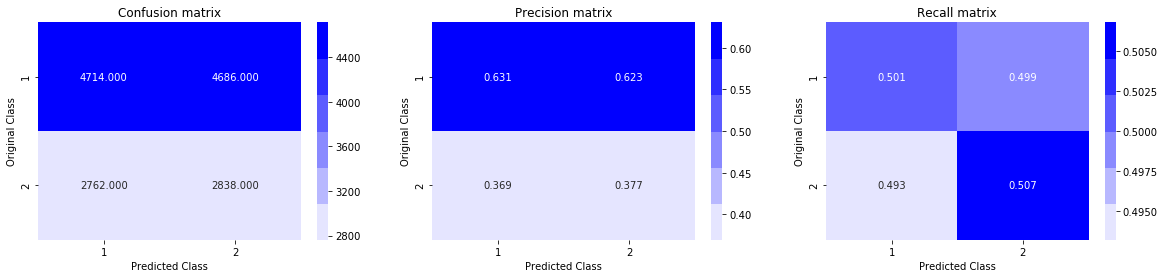

In [94]:
predicted_y = np.zeros((test_len, 2))

for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])

print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps = 1e-15))

predicted_y = np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

# Logistic Regression with Hyperparameter Tuning

For values of alpha =  1e-05 The log loss is: 0.42150882312976923
For values of alpha =  0.0001 The log loss is: 0.4227130968358387
For values of alpha =  0.001 The log loss is: 0.42591685127960466
For values of alpha =  0.01 The log loss is: 0.44480068919435606
For values of alpha =  0.1 The log loss is: 0.46234921158677555
For values of alpha =  1 The log loss is: 0.4938235946324831
For values of alpha =  10 The log loss is: 0.5447677661757477


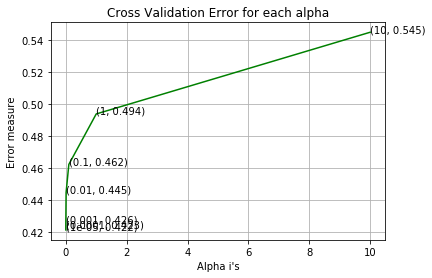

For values of best alpha =  1e-05 The train log loss is: 0.4121890377696049
For values of best alpha =  1e-05 The test log loss is: 0.42150882312976923
Total number of data points :  15000


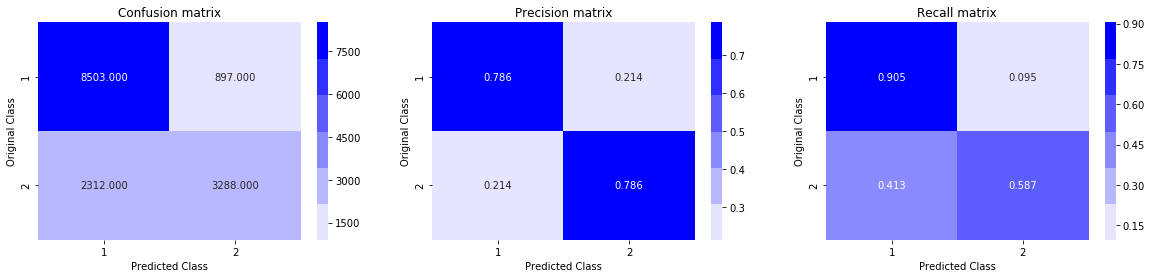

In [95]:
alpha = [10 ** x for x in range(-5, 2)] 

log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha = i, penalty='l2', loss='log', random_state = 5)
    clf.fit(X_train_s1, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_s1, y_train)
    predict_y = sig_clf.predict_proba(X_test_s1)
    log_error_array.append(log_loss(y_test, predict_y, labels = clf.classes_, eps = 1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels = clf.classes_, eps = 1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array, c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i], np.round(txt,3)), (alpha[i], log_error_array[i]))

plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state = 5)
clf.fit(X_train_s1, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_s1, y_train)

predict_y = sig_clf.predict_proba(X_train_s1)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_s1)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y = np.argmax(predict_y, axis=1)
print("Total number of data points : ", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Linear SVM with Hyperparameter Tuning

For values of alpha =  1e-05 The log loss is: 0.44122426606865445
For values of alpha =  0.0001 The log loss is: 0.4594414147876107
For values of alpha =  0.001 The log loss is: 0.47937219149563715
For values of alpha =  0.01 The log loss is: 0.49964642247254404
For values of alpha =  0.1 The log loss is: 0.49654406568727366
For values of alpha =  1 The log loss is: 0.5697232319961436
For values of alpha =  10 The log loss is: 0.6329082675889889


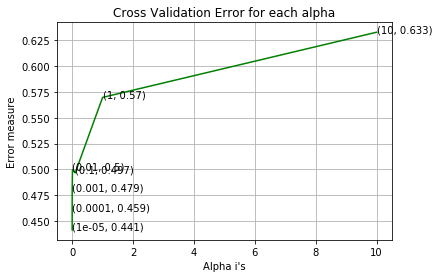

For values of best alpha =  1e-05 The train log loss is: 0.4264999048498056
For values of best alpha =  1e-05 The test log loss is: 0.44122426606865445
Total number of data points : 15000


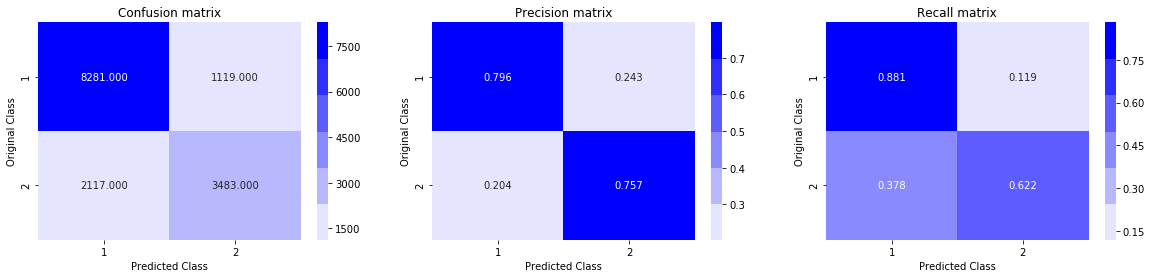

In [96]:
alpha = [10 ** x for x in range(-5, 2)] 

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha = i, penalty='l1', loss = 'hinge', random_state = 5)
    clf.fit(X_train_s1, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_s1, y_train)
    predict_y = sig_clf.predict_proba(X_test_s1)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))

plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha = alpha[best_alpha], penalty = 'l1', loss = 'hinge', random_state = 5)
clf.fit(X_train_s1, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_s1, y_train)

predict_y = sig_clf.predict_proba(X_train_s1)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_s1)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# XGBoost Model 

In [99]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import log_loss

param_grid = {'n_estimators' : [5, 10, 100, 500], 'max_depth' : [2, 5, 8, 10]}

rs = RandomizedSearchCV(estimator = XGBClassifier(objective = 'binary:logistic', eval_metric = 'logloss', eta = 0.02), param_distributions = param_grid)

# fit train sets
rs.fit(X_train_s1, y_train)

# Prediction
predict = rs.predict(X_test_s1)

In [100]:
b_para = rs.best_params_
b_score = rs.best_score_

print("Optimal hyperParameter:", b_para)
print("Maximum accuracy:", b_score * 100)

Optimal hyperParameter: {'n_estimators': 500, 'max_depth': 10}
Maximum accuracy: 83.53777777777779


# Confusion Matrix

Total number of data points :  15000


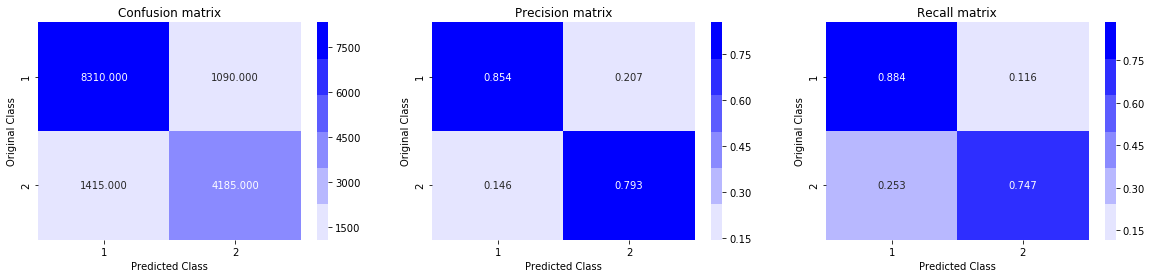

In [101]:
predicted_y = np.array(predict > 0.5, dtype = int)

print("Total number of data points : ", len(predicted_y))

plot_confusion_matrix(y_test, predicted_y)

In [103]:
import xgboost as xg
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 10
params['n_estimators'] = 100

d_train = xg.DMatrix(X_train_s1, label= y_train)
d_test = xg.DMatrix(X_test_s1, label = y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xg.train(params, d_train, 400, watchlist, early_stopping_rounds=20)

xgdmat = xg.DMatrix(X_train_s1, y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, eps=1e-15))

[10:04:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.68217	valid-logloss:0.68294
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[1]	train-logloss:0.67166	valid-logloss:0.67313
[2]	train-logloss:0.66157	valid-logloss:0.66370
[3]	train-logloss:0.65183	valid-logloss:0.65463
[4]	train-logloss:0.64242	valid-logloss:0.64592
[5]	train-logloss:0.63330	valid-logloss:0.63748
[6]	train-logloss:0.62457	valid-logloss:0.62938
[7]	train-logloss:0.61615	valid-logloss:0.62168
[8]	train-logloss:0.60797	valid-logloss:0.61417
[9]	train-logloss:0.60007	v

[156]	train-logloss:0.28818	valid-logloss:0.35292
[157]	train-logloss:0.28770	valid-logloss:0.35270
[158]	train-logloss:0.28737	valid-logloss:0.35251
[159]	train-logloss:0.28698	valid-logloss:0.35223
[160]	train-logloss:0.28642	valid-logloss:0.35196
[161]	train-logloss:0.28605	valid-logloss:0.35172
[162]	train-logloss:0.28574	valid-logloss:0.35152
[163]	train-logloss:0.28520	valid-logloss:0.35129
[164]	train-logloss:0.28488	valid-logloss:0.35108
[165]	train-logloss:0.28449	valid-logloss:0.35088
[166]	train-logloss:0.28404	valid-logloss:0.35068
[167]	train-logloss:0.28376	valid-logloss:0.35049
[168]	train-logloss:0.28340	valid-logloss:0.35031
[169]	train-logloss:0.28311	valid-logloss:0.35013
[170]	train-logloss:0.28278	valid-logloss:0.34997
[171]	train-logloss:0.28247	valid-logloss:0.34981
[172]	train-logloss:0.28215	valid-logloss:0.34961
[173]	train-logloss:0.28184	valid-logloss:0.34941
[174]	train-logloss:0.28154	valid-logloss:0.34926
[175]	train-logloss:0.28132	valid-logloss:0.34914


[320]	train-logloss:0.25914	valid-logloss:0.33871
[321]	train-logloss:0.25904	valid-logloss:0.33869
[322]	train-logloss:0.25891	valid-logloss:0.33863
[323]	train-logloss:0.25872	valid-logloss:0.33854
[324]	train-logloss:0.25864	valid-logloss:0.33850
[325]	train-logloss:0.25854	valid-logloss:0.33849
[326]	train-logloss:0.25844	valid-logloss:0.33847
[327]	train-logloss:0.25834	valid-logloss:0.33846
[328]	train-logloss:0.25827	valid-logloss:0.33842
[329]	train-logloss:0.25820	valid-logloss:0.33841
[330]	train-logloss:0.25807	valid-logloss:0.33835
[331]	train-logloss:0.25798	valid-logloss:0.33832
[332]	train-logloss:0.25780	valid-logloss:0.33827
[333]	train-logloss:0.25773	valid-logloss:0.33824
[334]	train-logloss:0.25757	valid-logloss:0.33817
[335]	train-logloss:0.25747	valid-logloss:0.33815
[336]	train-logloss:0.25736	valid-logloss:0.33810
[337]	train-logloss:0.25732	valid-logloss:0.33807
[338]	train-logloss:0.25725	valid-logloss:0.33804
[339]	train-logloss:0.25716	valid-logloss:0.33802


In [107]:
from prettytable import PrettyTable

pt = PrettyTable()
pt.field_names = ['No.', 'Model Name', 'Hyperparameter Tunning', 'Test Log-Loss']
pt.add_row(["1","Random (Tf-Idf W2V)", "No", "0.887"])
pt.add_row(["2","Logistic Regression (Tf-Idf W2V)", "Yes", "0.471"])
pt.add_row(["3","Linear SVM (Tf-Idf W2V)", "Yes", "0.476"])
pt.add_row(["4","XGBoost (Tf-Idf W2V)", "No", "0.404"])
pt.add_row(["\n","\n","\n","\n"])
pt.add_row(["1","Random (Tf-Idf)", "No", "0.882"])
pt.add_row(["2","Logistic Regression (Tf-Idf)", "Yes", "0.421"])
pt.add_row(["3","Linear SVM (Tf-Idf)", "Yes", "0.441"])
pt.add_row(["4","XGBoost (Tf-Idf)", "Yes", "0.336"])

print(pt)

+-----+----------------------------------+------------------------+---------------+
| No. |            Model Name            | Hyperparameter Tunning | Test Log-Loss |
+-----+----------------------------------+------------------------+---------------+
|  1  |       Random (Tf-Idf W2V)        |           No           |     0.887     |
|  2  | Logistic Regression (Tf-Idf W2V) |          Yes           |     0.471     |
|  3  |     Linear SVM (Tf-Idf W2V)      |          Yes           |     0.476     |
|  4  |       XGBoost (Tf-Idf W2V)       |           No           |     0.404     |
|     |                                  |                        |               |
|     |                                  |                        |               |
|  1  |         Random (Tf-Idf)          |           No           |     0.882     |
|  2  |   Logistic Regression (Tf-Idf)   |          Yes           |     0.421     |
|  3  |       Linear SVM (Tf-Idf)        |          Yes           |     0.44

<h1><font color=red> Procedure Followed </font></h1>

<b> PROBLEM STATEMENT :  </b> We have given a Dataset from Quora in which they have given 5 features ( id of question1, id of question 2, question 1, question 2, is duplicate). Based on these features (excluding is_duplicate feature) we need to predict whether the given pair of question is duplicate or not.

<b> STEP 1 : </b> We have total 404290 number of datapoints. First we have check the distribution that how many datapoints says that the pair is duplicate and how many datapoints say that the pair is not duplicate. Knowing Distribution of our datapoints helps us a lot.

<b> STEP 2 : </b> After knowing the distribution of datapoints we just checked in our dataset how many question are unique, how many questions repeated, is there any question pair which is duplicate?. These will give us the insight of our dataset and helps us to know our dataset better.

<b> STEP 3 : </b> Then we did some basic feature engineering so that we can get some features that represent the underlying problem better to the model. We just included some basic features like Frequency of questions, length of questions, total number of words in questions, etc. And after Basic feature extraction we performed EDA on that. By doing EDA we can do thorough analysis of features.

<b> STEP 4 : </b> After Preprocessing our data we did some advance Feature engineering using Fussy features and plot word clouds, pair plot, etc. And we have visualize advance features using PCA.

<b> STEP 5 : </b> In provided notebooks there was a <font color=red> PROBLEM OF DATA LEAKAGE </font>. So to avoid data leakage problem we need to split our data first into train, test data and then vectorize text data for both train and test data. So we randomly split our data.

<b> STEP 6 : </b> Now after splitting our data we will vectorize our text data (Question 1 and Question 2) using Tf-Idf vectorizer. Then we will merge all the features ( Basic features, advance features, Tf-Idf vectorized question 1 and question 2). Since now we have merged all our features so we apply models on it.

<b> STEP 7 : </b> Since we are also using the probabily values we will consider log-loss as a performace matrix. Along with log-loss we will also use Binary confusion matrix.

<b> STEP 8 : </b> Before applying any other model we need to understand the worst case log-loss. And we can know the worst case log-loss by building a random model in which we randomly allocate label. It can also act as a baseline model. We got the worst case log-loss of 0.88 on the dumb model. Now any other model that we use have the log-loss less than this dumb model.

<b> STEP 9 : </b> Now we will apply Logistic regression model on our training data. And then we will perform hyper parameter tuning to reduce the log-loss. The log-loss we have got after hyperparameter tuning on test data is 0.421, which is less than the worst-case log-loss.

<b> STEP 10 : </b> Now we have applied Linear SVM model with hyperparameter tuning. By Linear SVM we got the log-loss of 0.441 which is less than the loss loss of random model. 

<b> STEP 11 : </b> After this we have applied XGBoost Model. We also perform hyperparameter tuning so that we can get low log-loss. The log-loss we got is 0.336. The log-loss that we have achieved on XGBoost is much low than the log-loss we have achieved on Logistic Regression and Linear SVM.

<b><font color=red> Conclusion </font></b> Since log-loss achieved on XGBoost is much lower than other models so we can conclude that we can use XGBoost model to find the duplicate questions on Quora.